In [103]:
#prep/import packages

import numpy as np
import glob
import rasterio
from rasterio.plot import show, show_hist
import geopandas as gpd
import pandas as pd
from scipy.spatial import cKDTree

In [104]:
#read list of rasters, show list
files = glob.glob(r'C:\Users\arom\Documents\School\Grad School\Fall 2020\Automation\week6\Lab4\data\data\*.tif')
files

['C:\\Users\\arom\\Documents\\School\\Grad School\\Fall 2020\\Automation\\week6\\Lab4\\data\\data\\protected_areas.tif',
 'C:\\Users\\arom\\Documents\\School\\Grad School\\Fall 2020\\Automation\\week6\\Lab4\\data\\data\\reclass_slope.tif',
 'C:\\Users\\arom\\Documents\\School\\Grad School\\Fall 2020\\Automation\\week6\\Lab4\\data\\data\\slope.tif',
 'C:\\Users\\arom\\Documents\\School\\Grad School\\Fall 2020\\Automation\\week6\\Lab4\\data\\data\\suitables_sites.tif',
 'C:\\Users\\arom\\Documents\\School\\Grad School\\Fall 2020\\Automation\\week6\\Lab4\\data\\data\\urban_areas.tif',
 'C:\\Users\\arom\\Documents\\School\\Grad School\\Fall 2020\\Automation\\week6\\Lab4\\data\\data\\water_bodies.tif',
 'C:\\Users\\arom\\Documents\\School\\Grad School\\Fall 2020\\Automation\\week6\\Lab4\\data\\data\\ws80m.tif']

In [105]:
#create empty array
empty_array = []

#open each raster, fix infinites, create moving window and take average
for i in files:
    with rasterio.open(i) as data:
        array = data.read(1)
        array = np.where(array < 0, 0, array)
        mean_a = np.zeros_like(array)
        
        for row in range(5, array.shape[0] - 5):
            for col in range(4, array.shape[1] - 4):
                window = array[row-5:row+5 +1, col - 4:col+4 +1]
                mean_a[row, col] = window.mean()
        empty_array.append(mean_a)

#apply suitable site conditions to each of the arrays to create booleans
#protected
empty_array[0] = np.where(empty_array[0] < 0.05, 1, 0)        
#slope
empty_array[2] = np.where(empty_array[2] < 15, 1, 0)
#urban 
empty_array[4] = np.where(empty_array[4] !=0, 0, 1)
#water
empty_array[5] = np.where(empty_array[5] < 0.02, 1, 0)
#wind
empty_array[6] = np.where(empty_array[6] < 8.5, 0, 1)

#sum arrays
array_sum = empty_array[0] + empty_array[2] + empty_array[4] + empty_array[5] + empty_array[6]


In [106]:
#create a final boolean array from the sum of the arrays
final_array = np.where(array_sum == 5, 1, 0)
print('The total number of suitable sites is', final_array.sum())

The total number of suitable sites is 753


In [107]:
#change dtype of the final boolean
final_array = final_array.astype('float64')

In [108]:
#create tif from final boolean
with rasterio.open(r'C:\Users\arom\Documents\School\Grad School\Fall 2020\Automation\week6\Lab4\data\data\slope.tif') as dataset:
        
    with rasterio.open(f'suitable_sites.tif', 'w',
                      driver='GTiff',
                      height=final_array.shape[0],
                      width=final_array.shape[1],
                      count=1,
                      dtype=final_array.dtype,
                      crs=dataset.crs,
                      transform = dataset.transform, 
                      nodata=-9999
                      ) as tif_dataset:
        tif_dataset.write(final_array,1)

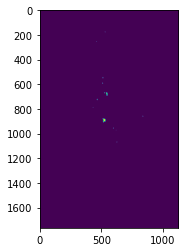

<AxesSubplot:>

In [109]:
#since the tif wasn't showing in Arc, open with rasterio, read as array, then show the array to see the suitable sites
with rasterio.open(r'C:\Users\arom\Documents\School\Grad School\Fall 2020\Automation\week6\Lab4\suitable_sites.tif') as dataset2:
    test_array = dataset2.read(1)
    
show(test_array)

In [110]:
#create a list of coordinates for the transmission stations
xs = []
ys = []
with open(r'C:\Users\arom\Documents\School\Grad School\Fall 2020\Automation\week6\Lab4\data\data\transmission_stations.txt') as coords:
    lines = coords.readlines()[1:]
    for l in lines:
        x,y = l.split(',')
        xs.append(float(x))
        ys.append(float(y))
    stations = np.vstack([xs, ys])
    stations = stations.T
    
#find centroids of suitable sites
with rasterio.open(r'C:\Users\arom\Documents\School\Grad School\Fall 2020\Automation\week6\Lab4\suitable_sites.tif') as file:
    
    bounds = file.bounds
    topLeft = (bounds[0], bounds[3])
    lowRight = (bounds[2], bounds[1])
    cellSize = 1000

    x_coords = np.arange(topLeft[0] + cellSize/2, lowRight[0], cellSize) 
    y_coords = np.arange(lowRight[1] + cellSize/2, topLeft[1], cellSize) 
    
    x, y = np.meshgrid(x_coords, y_coords)
    cent_coords = np.c_[x.flatten(), y.flatten()]

#multiply total centroids by the final boolean in part 1 to get the final list of centroids
suitable_cent_coords = []
for sx, sy in zip(cent_coords, final_array.flatten()):
        sxcoord = np.multiply(sx[0], sy)
        sycoord = np.multiply(sx[1], sy)
        if sxcoord != 0 and sycoord != 0:
            suitable_cent_coords.append([sxcoord, sycoord])    

In [111]:
#run nearest neighbor, convert from meters to kilometers, print result
dist, i = cKDTree(stations).query(suitable_cent_coords)
print('The shortest distance is:',np.min(dist)/1000,'kilometers, and the maximum distance is:',np.max(dist)/1000,'kilometers')

The shortest distance is: 4.124829386843891 kilometers, and the maximum distance is: 150.51185187753342 kilometers
